<a href="https://colab.research.google.com/github/manuelrucci7/deep-learning-course/blob/main/colab/Ultralytics_Understand_Outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ultralytics Get Otputs

* [Github Ultralytics](https://github.com/ultralytics/ultralytics/tree/main)
* [COCO classes](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco.yaml)
* [Documentation](https://docs.ultralytics.com/)

In [5]:
# Install ultralytics
%%capture
!pip install ultralytics

In [6]:
# check gpu
!nvidia-smi

Mon May 13 20:13:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
%%capture
!wget https://ultralytics.com/images/bus.jpg

In [11]:
from ultralytics import YOLO
import cv2
import time
import torch
import numpy as np
from PIL import Image

# Load model Detect
model = YOLO("yolov8n.pt")
#model = YOLO("yolov8s.pt")
#model = YOLO("yolov8m.pt")
#model = YOLO("yolov8l.pt")
#model = YOLO("yolov8x.pt")

#model = YOLO("yolov8n-seg.pt")
#model = YOLO("yolov8s-seg.pt")
#model = YOLO("yolov8m-seg.pt")
#model = YOLO("yolov8l-seg.pt")
#model = YOLO("yolov8x-seg.pt")

# Read image by default opencv read as BGR, we want RGB
im = cv2.imread("bus.jpg", 1) # BGR
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Load model to gpu (cuda)
device = torch.device("cuda")
model = model.to(device)
print(f"Device: {model.device}")

# Run inference
imgs = [im]
results = model.predict(imgs, imgsz=640, conf=0.1, iou=0.5, verbose=False)

Device: cuda:0


Model selected does not have segmentation option!


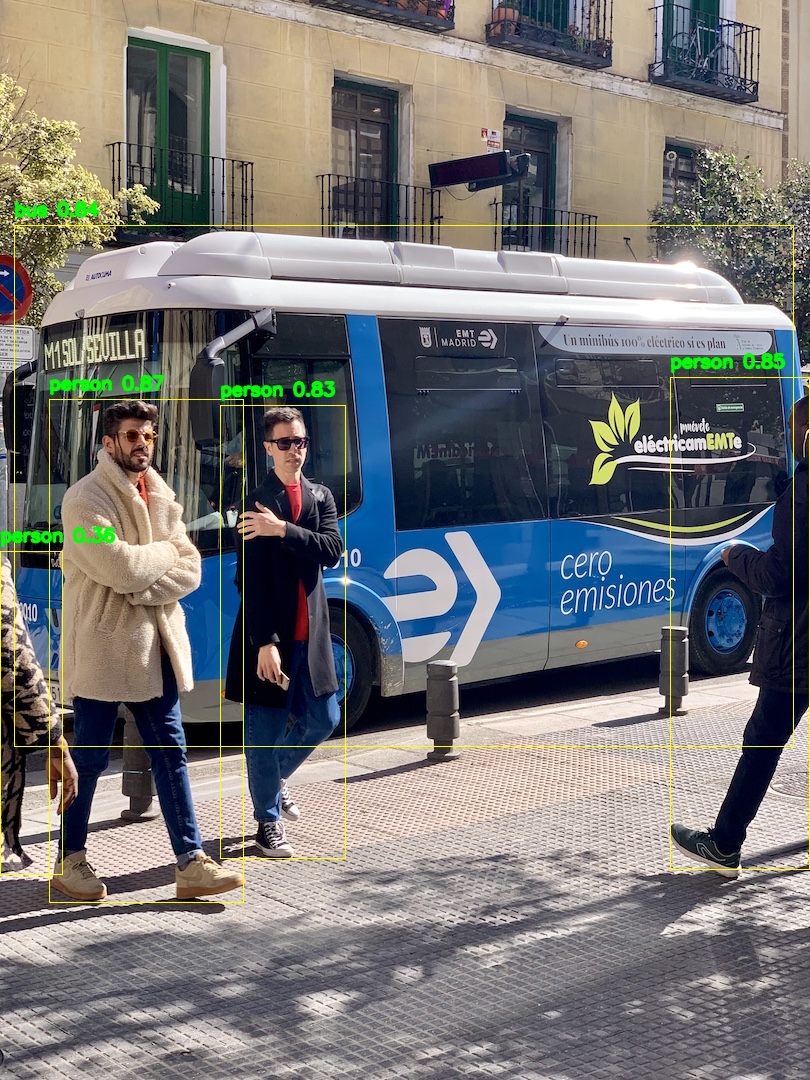

In [12]:
for img, res in zip(imgs, results):
    img_draw = img.copy()
    boxes = res.boxes.xyxy.cpu().numpy()
    scores = res.boxes.conf.cpu().numpy()
    classes_id = res.boxes.cls.cpu().numpy()

    if res.masks is not None:
        masks =  res.masks.data.cpu().numpy()
    else:
        print("Model selected does not have segmentation option!")

    for i in range(0, len(scores)):
        box = boxes[i]
        score = scores[i]
        class_id = classes_id[i]
        if score>0.3:
            xl, yl, xr, yr = box.astype(int)
            text = model.names[class_id] + f" {score:.2f}"
            cv2.rectangle( img_draw, (xl, yl), (xr,yr), (255,255,0), 1)
            cv2.putText(img_draw, text, (xl,yl-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6 ,(0,255,0), 2,  cv2.LINE_AA)

            if res.masks is not None:
                mask = masks[i]
                mask = (mask*255).astype(np.uint8)
                mask = cv2.resize(mask,  (img.shape[1],img.shape[0]), cv2.INTER_AREA)
                #contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                #cv2.drawContours(img_draw, contours, -1, (0,255,0),1)
                masked_color = np.zeros((mask.shape[0],mask.shape[1],3), dtype=np.uint8)
                masked_color[mask==255] = (0, 255, 255)  # Set the desired color here (BGR format)
                img_draw = cv2.addWeighted(img_draw, 1, masked_color, 0.6, 0)


    display(Image.fromarray(img_draw))


## Example to blur person from image

100%|██████████| 49.7M/49.7M [00:00<00:00, 239MB/s]


Device: cuda:0
Model selected does not have segmentation option!


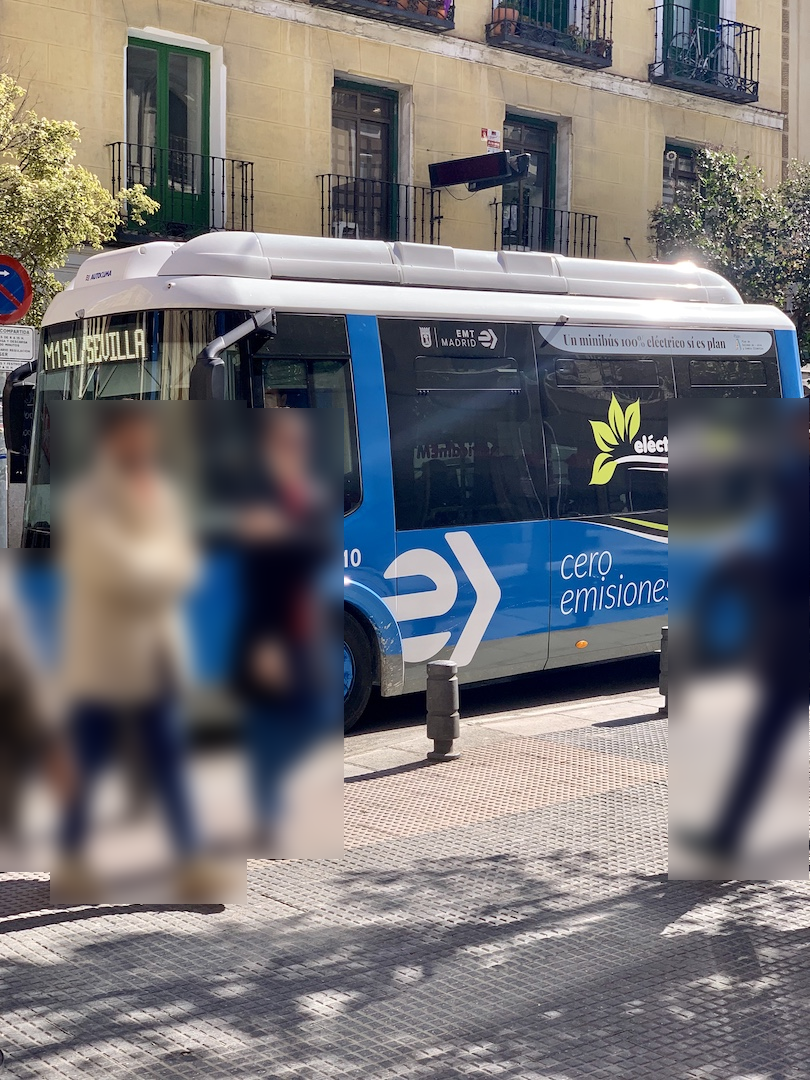

In [32]:
from ultralytics import YOLO
import cv2
import time
import torch
import numpy as np
from PIL import Image

def blur_persons(image, combined_mask, blur_ksize=(71, 71)):
    # Ensure the combined mask is binary
    _, combined_mask = cv2.threshold(combined_mask, 128, 255, cv2.THRESH_BINARY)

    # Invert the mask to get the persons mask
    mask_inv = cv2.bitwise_not(combined_mask)

    # Blur the input image to create the blurred persons
    blurred_persons = cv2.GaussianBlur(image, blur_ksize, 0)

    # Extract the blurred persons using the combined mask
    blurred_foreground = cv2.bitwise_and(blurred_persons, blurred_persons, mask=combined_mask)

    # Extract the sharp background using the inverted mask
    sharp_background = cv2.bitwise_and(image, image, mask=mask_inv)

    # Combine the blurred persons and the sharp background
    result = cv2.add(blurred_foreground, sharp_background)

    return result

def blur_background(image, combined_mask, blur_ksize=(71, 71)):
    # Ensure the combined mask is binary
    _, combined_mask = cv2.threshold(combined_mask, 128, 255, cv2.THRESH_BINARY)

    # Invert the mask to get the background mask
    mask_inv = cv2.bitwise_not(combined_mask)

    # Blur the input image to create the blurred background
    blurred_background = cv2.GaussianBlur(image, blur_ksize, 0)

    # Extract the sharp persons using the combined mask
    sharp_foreground = cv2.bitwise_and(image, image, mask=combined_mask)

    # Extract the blurred background using the inverted mask
    blurred_background_part = cv2.bitwise_and(blurred_background, blurred_background, mask=mask_inv)

    # Combine the sharp persons and the blurred background
    result = cv2.add(sharp_foreground, blurred_background_part)

    return result

# Read image by default opencv read as BGR, we want RGB
im = cv2.imread("bus.jpg", 1) # BGR
#im = cv2.imread("photo.jpg", 1) # BGR
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Load model to gpu (cuda)
#model = YOLO("yolov8m-seg.pt")
model = YOLO("yolov8m.pt")
device = torch.device("cuda")
model = model.to(device)
print(f"Device: {model.device}")

# Run inference
imgs = [im]
results = model.predict(imgs, imgsz=640, conf=0.1, iou=0.5, verbose=False)

# Initialize combined mask
combined_mask = np.zeros(im.shape[:2], dtype=np.uint8)

for img, res in zip(imgs, results):
    boxes = res.boxes.xyxy.cpu().numpy()
    scores = res.boxes.conf.cpu().numpy()
    classes_id = res.boxes.cls.cpu().numpy()

    if res.masks is not None:
        masks = res.masks.data.cpu().numpy()
    else:
        print("Model selected does not have segmentation option!")

    # Combine masks of all detected persons
    for i in range(len(scores)):
        box = boxes[i]
        score = scores[i]
        class_id = classes_id[i]
        name = model.names[class_id]

        if score > 0.3 and name == "person":
            if res.masks is not None:
                mask = masks[i]
                mask = (mask * 255).astype(np.uint8)
                mask = cv2.resize(mask, (im.shape[1], im.shape[0]), cv2.INTER_AREA)
                combined_mask = cv2.bitwise_or(combined_mask, mask)
            else:
                x1, y1, x2, y2 = box.astype(int)
                combined_mask[y1:y2, x1:x2] = 255

result = blur_persons(img, combined_mask)
#result = blur_background(img, combined_mask)

display(Image.fromarray(result))